# Settings

In this notebook we work with the problem of multi-class classification, that is, the correct assignment of an object to one of the classes. Our goal is to achieve high accuracy of assignment to the correct category. We will use the widely used transfer learning method.


Transfer learning is a machine learning technique that uses a pre-trained model. In this approach, a model trained on one data is used or retrained for use with another set of data. By using transfer learning, you can achieve significantly higher classification accuracy, especially when the available data set is limited.

Before running the code, we need to make sure that we are using the GPU. We plan to work with a convolutional neural network, and using a GPU allows us to reduce training time by several times.

In [1]:
# display information about available GPU devices
!nvidia-smi

Thu Jan 11 14:44:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Import libraries

In [2]:
# Visualization purpose
!pip install tensorboardX
!pip install tensorboard
!pip install tensorboard-plugin-customizable-plots

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 4.3 MB/s eta 0:00:00


In [3]:
!pip install split-folders
!pip install optuna
!pip install --upgrade nvidia-ml-py3


  Preparing metadata (setup.py) ... - \ done
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19189 sha256=65005bdb5676bc71f4a5f932f53bc737ed02e8447b87abac216588305e214b91
  Stored in directory: /root/.cache/pip/wheels/5c/d8/c0/46899f8be7a75a2ffd197a23c8797700ea858b9b34819fbf9e
Successfully built nvidia-ml-py3


In [4]:
import os
import shutil
import splitfolders
from pathlib import Path
import imghdr
import numpy as np
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt 
import random
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Description of the data set

The set used has about 22,000 images of various types of waste, divided into 10 different categories - metal, glass, biological waste, etc.


# Data Preprcessing

In [5]:
data_dir = '/kaggle/input/garbage-classification-v2/'

Cleaning the working directory if there are any files in it

In [6]:
def remove_folder_contents(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                remove_folder_contents(file_path)
                os.rmdir(file_path)
        except Exception as e:
            print(e)

folder_path = '/kaggle/working'
remove_folder_contents(folder_path)
# os.rmdir(folder_path)

Copying the dataset to the working directory to allow data cleaning

In [7]:
shutil.copytree(data_dir, '/kaggle/working/dataset')

'/kaggle/working/dataset'

In [8]:
data_dir  = '/kaggle/working/dataset'

In [9]:
experiment_name = "Transfer Learning"

The Tensorflow library that we are going to use does not support some image formats, in addition, the dataset may have corrupted or non-image files. Let's pre-clean the dataset.

In [10]:
count=0
image_extensions = [".png", ".jpg"] 
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]

for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        if img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)
            count+=1
print(f"Removed {count} images")

/kaggle/working/dataset/metal/metal_1441.jpg is not an image
/kaggle/working/dataset/metal/metal_1441.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/glass/glass_4463.jpg is not an image
/kaggle/working/dataset/glass/glass_4463.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/glass/glass_4432.jpg is not an image
/kaggle/working/dataset/glass/glass_4432.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/glass/glass_4413.jpg is not an image
/kaggle/working/dataset/glass/glass_4413.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/glass/glass_2835.jpg is not an image
/kaggle/working/dataset/glass/glass_2835.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/glass/glass_4727.jpg is not an image
/kaggle/working/dataset/glass/glass_4727.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/glass/glass_2014.jpg is not an image
/kaggle/working/dataset/glass/glass_2014.jpg is a None, not accepted by Ten

To train the model, you will need to divide the data into several samples, so we will create folders for them

In [11]:
os.mkdir('data')

In [12]:
os.chdir('data')

In [13]:
os.getcwd()

'/kaggle/working/data'

In [14]:
os.mkdir('train')
os.mkdir('test')
os.mkdir('val')

In [15]:
os.chdir('/kaggle/working/')

In [16]:
os.getcwd()

'/kaggle/working'

Let's set a random value for reproducibility of the result. In particular, when splitting the dataset randomly (as in the following block of code), a fixed SEED value ensures that we get exactly the same split of data next time.

In [17]:
SEED = 42

Let's divide the data from the dataset into three folders - for training and test samples.

In [18]:
splitfolders.ratio("/kaggle/working/dataset", output = 'data', seed = SEED, ratio = (.8,.1,.1), group_prefix = None)

Copying files: 23584 files [00:03, 5992.47 files/s]


In [19]:
data_dir

'/kaggle/working/dataset'

You can now delete the unused dataset folder to save space.

In [20]:
try:
    shutil.rmtree(data_dir)
except OSError as e:
    print("Error: %s : %s" % (data_dir, e.strerror))

Setting paths to training and test data

In [21]:
train_path = '/kaggle/working/data/train'
val_path = '/kaggle/working/data/val'
test_path = '/kaggle/working/data/test'

Visualization of data from a dataset

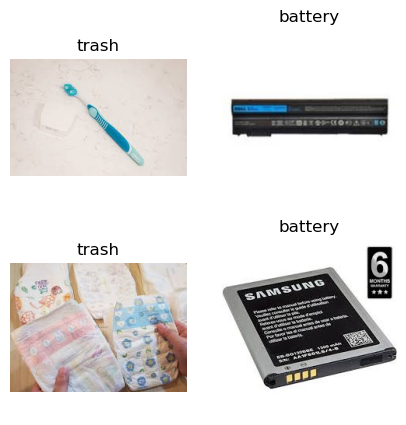

In [22]:
fig, axes = plt.subplots(2, 2, figsize = (5,5)) #выведем 4 изображения
axes = axes.ravel() 

for i in np.arange(0, 4): 

    category = random.choice(os.listdir(train_path)) #случайный выбор класса
    class_dir = os.path.join(train_path, category)

    image = random.choice(os.listdir(class_dir)) #cлучайный выбор изображения из класса
 
    img = plt.imread(os.path.join(class_dir,image))
    axes[i].imshow( img )
    axes[i].set_title(category) 
    axes[i].axis('off')

Let's look at the distribution of data between classes.

In [23]:
total = 0
for category in os.listdir(train_path):
    count= 0
    for image in os.listdir(train_path + "/" + category):
        count += 1
        total +=1
    print(str(category).title() + ": " + str(count))  
print(f"\nTotal number of train images: {total}")

Clothes: 4260
Trash: 667
Metal: 1494
Battery: 756
Glass: 3272
Plastic: 2013
Paper: 2169
Cardboard: 1864
Biological: 788
Shoes: 1581

Total number of train images: 18864


It is noticeable that in some classes the number of images differs several times. Let's visualize the distribution of classes for clarity.

In [24]:
# class names
class_names = sorted(os.listdir(train_path))
class_names

['battery',
 'biological',
 'cardboard',
 'clothes',
 'glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash']

In [25]:
class_dis = [len(os.listdir(train_path + f"/{name}")) for name in class_names]
class_dis

[756, 788, 1864, 4260, 3272, 1494, 2169, 2013, 1581, 667]

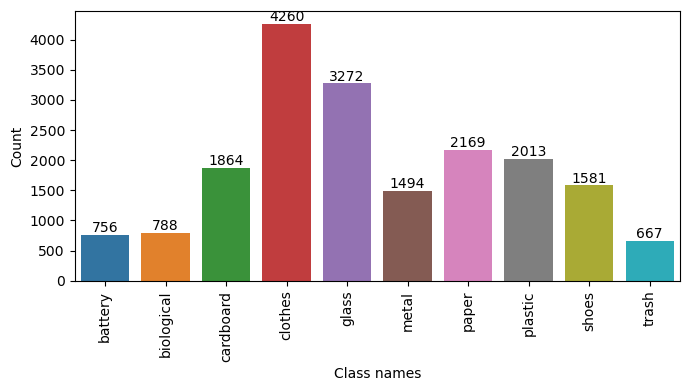

In [26]:
DF = pd.DataFrame(columns=['Class names','Count'])
DF['Class names']=class_names
DF['Count']=class_dis
plt.figure(figsize=(7,4))
ax=sns.barplot(x='Class names', y='Count', data=DF)
ax.bar_label(ax.containers[0])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()

A situation where one or more classes contain a significantly larger number of images is called class imbalance. In our situation, it is natural and determined by the specifics of the data. Thus, there are many more varieties of clothing or glass objects than batteries. However, this may negatively affect the training results of the model and cause it to be biased towards the largest class (that is, it will be much worse at classifying smaller classes). There are different approaches to solving this problem, the applicability of which depends on the problem being solved. We will use the method of insufficient sampling (*random undersampling*), which consists of randomly excluding some examples from large classes.

Excluding some random images from the training data

In [27]:
for category in os.listdir(train_path):
    count = 0
    delete = 0
    for image in os.listdir(train_path + '/'  + category):
        count += 1
        while count > 1000:
            random_image = random.choice(os.listdir(train_path + '/' + category)) 
            delete_image = train_path + '/'  + category +  '/' + random_image
            os.remove(delete_image)
            delete+=1
            count-=1
           
    print(f'Deleted {delete} in {category}')


Deleted 3260 in clothes
Deleted 0 in trash
Deleted 494 in metal
Deleted 0 in battery
Deleted 2272 in glass
Deleted 1013 in plastic
Deleted 1169 in paper
Deleted 864 in cardboard
Deleted 0 in biological
Deleted 581 in shoes


We limited the number of images in large classes to 1000. Let's see what the class distribution looks like now

In [28]:
class_dis = [len(os.listdir(train_path + f"/{name}")) for name in class_names]

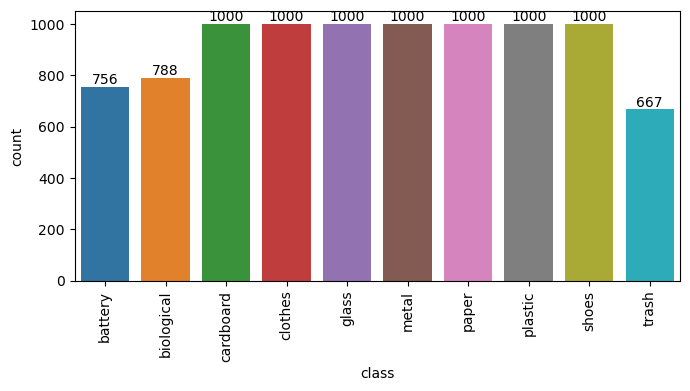

In [29]:
DF = pd.DataFrame(columns=['class','count'])
DF['class']=class_names
DF['count']=class_dis
plt.figure(figsize=(7,4))
ax=sns.barplot(x='class', y='count', data=DF)
ax.bar_label(ax.containers[0])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()

The data distribution now looks much better, although some image classes are still quite sparse. We will try to solve this problem using augmentation methods that we integrate into the model.

In [30]:
data_path = '/kaggle/working/data'

To train a neural network, it is necessary to ensure unification of image sizes. To do this, let’s find the average width and height of images in the entire dataset.

In [31]:
width = []
height = []
from PIL import Image
import numpy as np

for dirname in os.listdir(data_path):
    for category in os.listdir(data_path + '/' + dirname):
        for image in os.listdir(data_path + '/' + dirname + '/' + category):
            img = Image.open(data_path + '/' + dirname + '/' + category + '/' + image)
            width.append(img.width)
            height.append(img.height)

print('Mean width: {:.4f}'.format(np.mean(width)))
print('Mean Height: {:.4f}'.format(np.mean(height)))

Mean width: 416.0122
Mean Height: 395.5285


Let's set the size of the input data (image size) taking into account the found average values

In [32]:
IMG_SIZE = (400, 400)

Let's set the size of the data package for loading images into the model in parts

In [33]:
BATCH_SIZE = 32


Create a SummaryWriter instance to write logs

In [34]:
writer = SummaryWriter()

Previously, we divided the entire amount of data into three sets. Now you need to prepare them for working with the model - distribute them into packages and add labels to them. Data packets generated from the train folder, constituting 80% of the total number of images, will be used to train the model, from the val(10%) folder - for checking during training and adjusting parameters, and from the test folder - to evaluate the accuracy of the model on new data not used during training.


In [35]:
train_data = tf.keras.utils.image_dataset_from_directory(train_path,
                                                         image_size=IMG_SIZE,
                                                         label_mode='categorical',
                                                         batch_size=BATCH_SIZE,
                                                         shuffle=True,
                                                         seed=SEED)

Found 9211 files belonging to 10 classes.


In [36]:
test_data = tf.keras.utils.image_dataset_from_directory(test_path,
                                                        image_size=IMG_SIZE,
                                                        label_mode='categorical',
                                                        batch_size=BATCH_SIZE,
                                                        shuffle=False)

Found 2366 files belonging to 10 classes.


In [37]:
validation_data = tf.keras.utils.image_dataset_from_directory(val_path,
                                                              image_size=IMG_SIZE,
                                                              label_mode='categorical',
                                                              batch_size=BATCH_SIZE,
                                                              shuffle=True,
                                                              seed=SEED)

Found 2354 files belonging to 10 classes.


Create directories for train and test logs and write logs to it 

In [38]:
train_log_dir = os.path.join("logs", experiment_name, "train")
test_log_dir = os.path.join("logs", experiment_name, "test")

os.makedirs(train_log_dir, exist_ok=True)
os.makedirs(test_log_dir, exist_ok=True)

train_writer = SummaryWriter(train_log_dir)
test_writer = SummaryWriter(test_log_dir)


# Building the model

When selecting a model, we examined the classification models available in Keras with pre-trained weights on the public ImageNet dataset, which includes about 1000 categories of various images (https://keras.io/api/applications/).
For our task, the most important parameter is the classification accuracy. Based on the accuracy values presented in the table (acc1, percentage of correct answers), the EfficientNetV2S model, which has 88 layers, was selected. Although the EfficientNetV2M and EfficientNetV2L models have higher accuracy, they have significantly higher weights.


Loading the model

In [39]:
base_model = tf.keras.applications.EfficientNetV2S(include_top=False,
                                                   weights='imagenet', 
                                                   input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

82420632/82420632 [==============================] - 3s 0us/step


Let's see what the architecture of the pretrained model looks like

In [40]:
base_model.summary()

Model: "efficientnetv2-s"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 400, 400, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 200, 200, 24  648         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

The architecture of the model we are using already has a Rescale layer, so we may not include an additional image normalization layer in our model.ь.

Let's freeze all layers of the pretrained model so that its parameters do not change during training.

In [41]:
base_model.trainable = False

Let's create a data augmentation layer to improve classification accuracy. This layer is active only during model training.

In [42]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                         tf.keras.layers.RandomRotation(0.2), 
                                         tf.keras.layers.RandomZoom(0.2),
                                         tf.keras.layers.RandomHeight(0.2),
                                         tf.keras.layers.RandomWidth(0.2),],
                                         name ="data_augmentation")

Let's see how this layer works with images from the training set.

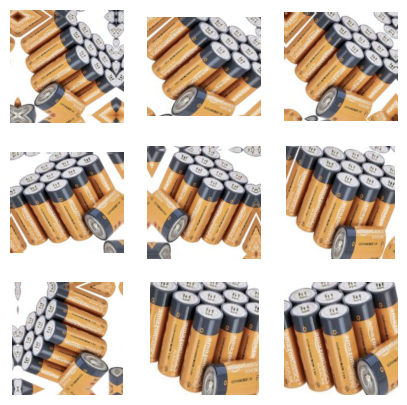

In [43]:
for image, _ in train_data.take(1):  
    plt.figure(figsize=(5, 5))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

Let's combine the model with the augmentation layer, and also add several layers:

* GlobalAveragePooling2D layer, which calculates the arithmetic average over all channels to combine feature maps
* A fully connected layer with 128 neurons and a Dropout layer, which excludes some neurons from the previous fully connected layer with a given probability, thereby reducing the possible effect of overfitting.
* Output fully connected layer with the number of outputs corresponding to the number of classes of our data.

In [44]:
name="EfficientNetV2S"

EfficientNetV2S_model=tf.keras.Sequential([tf.keras.Input(shape=(None, None, 3), name="input_layer"),
                    data_augmentation,
                    base_model,
                    tf.keras.layers.GlobalAveragePooling2D(),
                    tf.keras.layers.Dense(128, activation='relu'),
                    tf.keras.layers.Dropout(0.2),
                    tf.keras.layers.Dense(len(class_names), activation='softmax')
                    ], name=name)

For training, we will define a loss function, an optimizer, and a tracked accuracy metric

In [45]:
EfficientNetV2S_model.compile(loss='categorical_crossentropy',
                              optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
                              metrics=['accuracy'])

Let's look at the structure of our model

In [46]:
EfficientNetV2S_model.summary()

Model: "EfficientNetV2S"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetv2-s (Functiona  (None, 13, 13, 1280)     20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                   

The summary already shows the advantage of using a pre-trained model - out of more than 20 million parameters, only 165 thousand are trainable, which will significantly reduce training time.

While training the models, we will use a callback function to stop training when the metrics being tracked stop improving. After this, we will save the trained model and weights for further use.

In [47]:
# def log_to_tensorboard(epoch, logs):
#         train_writer.add_scalar('loss', logs['loss'], epoch)
#         train_writer.add_scalar('accuracy', logs['accuracy'], epoch)
#         test_writer.add_scalar('val_loss', logs['val_loss'], epoch)
#         test_writer.add_scalar('val_accuracy', logs['val_accuracy'], epoch)
def log_to_tensorboard(epoch, logs):
    train_writer.add_scalar('loss', logs['loss'], epoch)
    train_writer.add_scalar('accuracy', logs['accuracy'], epoch)
    
    # Use get method with a default value of None to avoid KeyError
    val_loss = logs.get('val_loss', None)
    val_accuracy = logs.get('val_accuracy', None)
    
    if val_loss is not None:
        test_writer.add_scalar('val_loss', val_loss, epoch)
    if val_accuracy is not None:
        test_writer.add_scalar('val_accuracy', val_accuracy, epoch)


# Creating a Callback Function
def create_callback(model_name):
    
    # termination of training when accuracy does not improve within 3 epochs
    early_stop = tf.keras.callbacks.EarlyStopping(patience=3,
                                                monitor="val_loss",
                                                mode="min",
                                                verbose=1)

    # decrease in learning rate when the error rate does not decrease over 2 epochs
    reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                              factor=0.2,
                                                              patience=2,
                                                              verbose=1,
                                                              min_lr=0.00001)

    log_to_tensorboard_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: log_to_tensorboard(epoch, logs))
    # saving model
    check_model = tf.keras.callbacks.ModelCheckpoint(model_name + ".h5",
                                                   monitor="val_accuracy",
                                                   mode="max",
                                                   save_best_only=True)
    callback = [early_stop, reduce_learning_rate, check_model, log_to_tensorboard_callback]
    return callback

In [48]:
EfficientNetV2S_callback = create_callback(name)

Let's set the number of training epochs

In [49]:
EPOCH=20

Let's train the model

In [50]:
import time
start_time = time.time()
EfficientNetV2S_history = EfficientNetV2S_model.fit(train_data, 
                                                    epochs=EPOCH, 
                                                    steps_per_epoch=len(train_data),
                                                    validation_data=validation_data, 
                                                    validation_steps=len(validation_data),
                                                    callbacks=EfficientNetV2S_callback)

Epoch 1/20


2024-01-11 14:50:50.544393: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNetV2S/efficientnetv2-s/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


288/288 [==============================] - 529s 2s/step - loss: 0.4476 - accuracy: 0.8611 - val_loss: 0.1783 - val_accuracy: 0.9469 - lr: 0.0010
Epoch 2/20
288/288 [==============================] - 460s 2s/step - loss: 0.2621 - accuracy: 0.9149 - val_loss: 0.1647 - val_accuracy: 0.9499 - lr: 0.0010
Epoch 3/20
288/288 [==============================] - 425s 1s/step - loss: 0.2202 - accuracy: 0.9283 - val_loss: 0.1428 - val_accuracy: 0.9618 - lr: 0.0010
Epoch 4/20
288/288 [==============================] - 388s 1s/step - loss: 0.1871 - accuracy: 0.9391 - val_loss: 0.1459 - val_accuracy: 0.9571 - lr: 0.0010
Epoch 5/20
288/288 [==============================] - 366s 1s/step - loss: 0.1631 - accuracy: 0.9455 - val_loss: 0.1268 - val_accuracy: 0.9652 - lr: 0.0010
Epoch 6/20
288/288 [==============================] - 349s 1s/step - loss: 0.1581 - accuracy: 0.9450 - val_loss: 0.1358 - val_accuracy: 0.9618 - lr: 0.0010
Epoch 7/20
288/288 [==============================] - 328s 1s/step - loss: 

Based on the training history, you can evaluate the effectiveness of using our callback function - after reducing the learning speed, the errors also decreased.

Out the logs folder for further analysis

In [51]:
import shutil

# Create a zip archive of the output folder
shutil.make_archive("/kaggle/working/logs", 'zip', "/kaggle/working/logs")

'/kaggle/working/logs.zip'

Let's look at the model training schedules.

In [52]:
end_time = time.time()
training_time = end_time - start_time
print("Total training time: {:.2f} seconds".format(training_time))
EfficientNetV2S_model.save("/kaggle/working/garbage-classification.h5")

Total training time: 5947.72 seconds


Close the SummaryWriter

In [53]:
writer.close()
train_writer.close()
test_writer.close()

In [54]:
EfficientNetV2S_history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [55]:
# Function for displaying training graphs
def plot_loss_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    
    epochs = range(len(history.history["loss"]))
    
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

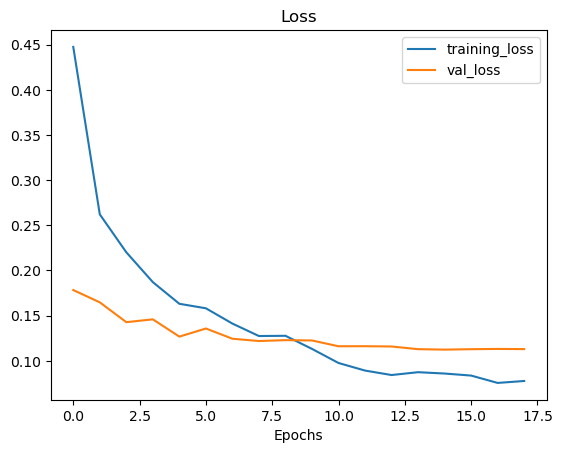

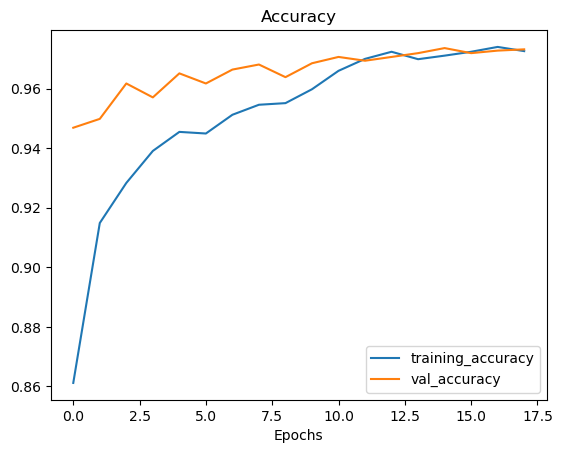

In [56]:
plot_loss_curves(EfficientNetV2S_history)

The learning curves look a little jumpy, but the dynamics look pretty good, there is a decrease in learning losses and an increase in testing accuracy.

# Model Evaluation

We use a set of test data to evaluate the accuracy of the model on new data

In [57]:
test_loss, test_accuracy = EfficientNetV2S_model.evaluate(test_data, verbose=0)

In [58]:
print("Test Loss: {:.5f}".format(test_loss))
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

Test Loss: 0.12224
Test Accuracy: 96.45%


Given the limited data set, we obtained a good accuracy of 97%.

Let's look at the main classification metrics

In [59]:
pred_probs = EfficientNetV2S_model.predict(test_data, verbose=1)

74/74 [==============================] - 31s 376ms/step


In [60]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [61]:
y_labels = []
for images, labels in test_data.unbatch(): 
    y_labels.append(labels.numpy().argmax()) 
y_labels[:10] 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Since the images in the test dataset were not shuffled, all the output labels correspond to the same class.

In [62]:
print('Classification Report \n')
target_names = class_names
print(classification_report(y_labels, pred_classes, target_names=target_names))

Classification Report 

              precision    recall  f1-score   support

     battery       0.99      0.96      0.97        95
  biological       0.98      0.99      0.98        99
   cardboard       0.95      0.97      0.96       234
     clothes       1.00      0.99      0.99       533
       glass       0.98      0.96      0.97       409
       metal       0.93      0.98      0.96       188
       paper       0.97      0.92      0.95       272
     plastic       0.92      0.95      0.94       253
       shoes       0.97      0.98      0.97       199
       trash       0.89      0.94      0.91        84

    accuracy                           0.96      2366
   macro avg       0.96      0.96      0.96      2366
weighted avg       0.97      0.96      0.96      2366



* The “Precision” column shows the percentage of correct predictions among all predictions for a particular class.
* The "Recall" column shows the percentage of images of a particular class that were predicted by the model to belong to that class.
* Column “F1” shows what percentage of model predictions were correct.
* The "Support" column shows how many images of each class were in the test dataset.

From the summary of metrics it is clear that the model classifies plastic worst of all, and best of all - things and various biological waste. However, despite the small data set, the model shows excellent performance in terms of Precision, Recall and F1 scores.

We visualize the error matrix to clearly see the correctness of class definitions

In [63]:
import itertools

In [64]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.around(cm, decimals=2)
    cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

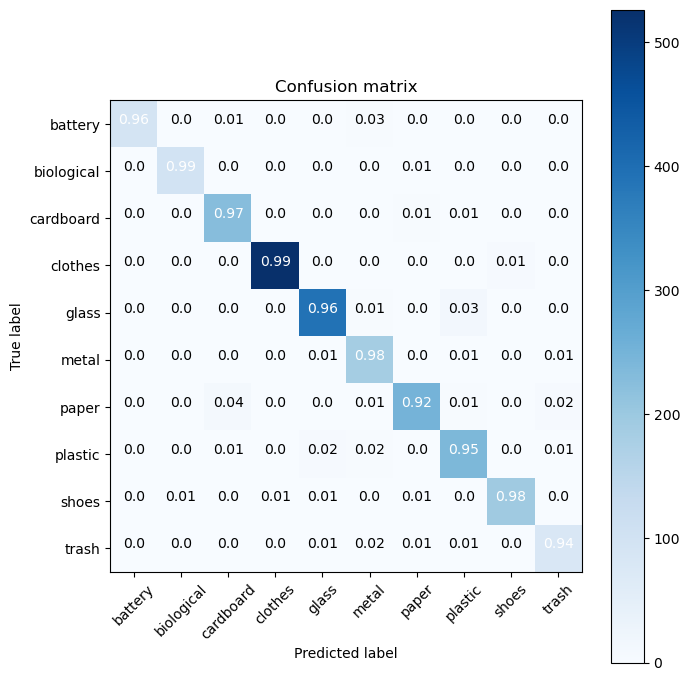

In [65]:
cm = confusion_matrix(y_labels, pred_classes)
plot_confusion_matrix(cm, class_names)

The rows of the matrix are responsible for the class predicted by the model, and the columns are for the actual class. From the error matrix, it is noticeable that in general the model’s errors are very small, although it sometimes incorrectly predicts categories, for example, it confuses plastic and glass.

Visualizing several model predictions

In [66]:
def pred_random_images(model_name, folder_path, class_names):
    plt.figure(figsize=(17, 10))
    for i in range(3):
        class_name = random.choice(class_names)
        filename = random.choice(os.listdir(folder_path + "/" + class_name))
        filepath = folder_path + "/" + class_name + "/" + filename
    
        img = tf.io.read_file(filepath)
        img = tf.image.decode_jpeg(img)
        img = tf.image.resize(img, [IMG_SIZE[0], IMG_SIZE[1]])
     #  img = img/255.
        pred_prob = model_name.predict(tf.expand_dims(img, axis=0), verbose=0) 
        pred_class = class_names[pred_prob.argmax()] 

  # Plot the image(s)
        plt.subplot(1, 3, i+1)
        plt.imshow(img/255.)
        if class_name == pred_class: 
            title_color = "g"
        else:
            title_color = "r"
        plt.title(f"Class: {class_name},\n Pred: {pred_class},\n Prob: {pred_prob.max():.2f}", c=title_color)
        plt.axis(False);

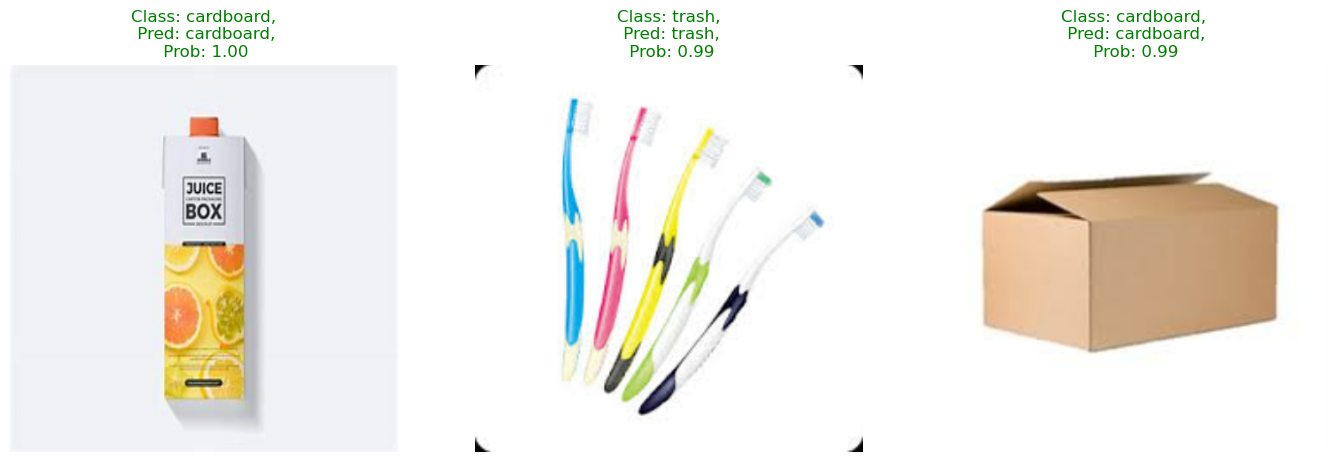

In [67]:
pred_random_images(EfficientNetV2S_model, test_path, class_names)

In [68]:
import pickle
pickle.dump(EfficientNetV2S_model,open("EfficientNetV2S_model.h5","wb"))
# EfficientNetV2S_model.save('EfficientNetV2S_model.h5')

In [69]:
ls ../working

EfficientNetV2S.h5        data/                      logs.zip
EfficientNetV2S_model.h5  garbage-classification.h5  runs/
__notebook__.ipynb        logs/


# Hyperparameter Tunning

We use Optuna for hyperparameter tunning. Here we are defining objective 

In [70]:
import optuna

In [71]:
def objective(trial):
    # hyperparameters to optimize
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    
    # Update the model with the suggested hyperparameters
    EfficientNetV2S_model = tf.keras.Sequential([
        tf.keras.Input(shape=(None, None, 3), name="input_layer"),
        data_augmentation,
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),  # Use the suggested dropout_rate directly
        tf.keras.layers.Dense(len(class_names), activation='softmax')
    ], name=name)
    
    # Update the model with the suggested hyperparameters
    EfficientNetV2S_model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )

    # Train the model with the updated hyperparameters
    history = EfficientNetV2S_model.fit(
        train_data,
        epochs=EPOCH,
        steps_per_epoch=len(train_data),
        validation_data=validation_data,
        validation_steps=len(validation_data),
        callbacks=EfficientNetV2S_callback
    )

    # Return the validation accuracy as the objective value to minimize
    return -history.history['val_accuracy'][-1]

In [72]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)  # You can adjust the number of trials

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2024-01-11 16:31:44,652] A new study created in memory with name: no-name-cfca46e0-2de7-42f3-8345-9c54f3aed307
/tmp/ipykernel_25/3119378495.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_25/3119378495.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


Epoch 1/20


2024-01-11 16:32:01.597036: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNetV2S/efficientnetv2-s/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


288/288 [==============================] - 260s 843ms/step - loss: 3.2697 - accuracy: 0.5753 - val_loss: 4.5553 - val_accuracy: 0.7243 - lr: 0.0843
Epoch 2/20
288/288 [==============================] - 245s 847ms/step - loss: 3.4353 - accuracy: 0.5175 - val_loss: 5.6426 - val_accuracy: 0.6631 - lr: 0.0843
Epoch 3/20
288/288 [==============================] - ETA: 0s - loss: 3.5761 - accuracy: 0.4633
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.01686896234750748.
288/288 [==============================] - 239s 830ms/step - loss: 3.5761 - accuracy: 0.4633 - val_loss: 4.6186 - val_accuracy: 0.6754 - lr: 0.0843
Epoch 4/20
288/288 [==============================] - 232s 804ms/step - loss: 2.3756 - accuracy: 0.4528 - val_loss: 2.9639 - val_accuracy: 0.6725 - lr: 0.0169
Epoch 5/20
288/288 [==============================] - 225s 780ms/step - loss: 1.8350 - accuracy: 0.4638 - val_loss: 2.8038 - val_accuracy: 0.6967 - lr: 0.0169
Epoch 6/20
288/288 [==============================] - 227

[I 2024-01-11 17:44:43,249] Trial 0 finished with value: -0.8164826035499573 and parameters: {'learning_rate': 0.08434481019146105, 'dropout_rate': 0.4455397080024042}. Best is trial 0 with value: -0.8164826035499573.


Epoch 1/20


2024-01-11 17:45:01.251726: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNetV2S/efficientnetv2-s/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


288/288 [==============================] - 215s 684ms/step - loss: 0.6329 - accuracy: 0.8231 - val_loss: 0.2340 - val_accuracy: 0.9308 - lr: 3.7344e-04
Epoch 2/20
288/288 [==============================] - 192s 664ms/step - loss: 0.3037 - accuracy: 0.9040 - val_loss: 0.1959 - val_accuracy: 0.9384 - lr: 3.7344e-04
Epoch 3/20
288/288 [==============================] - 194s 673ms/step - loss: 0.2567 - accuracy: 0.9161 - val_loss: 0.1680 - val_accuracy: 0.9473 - lr: 3.7344e-04
Epoch 4/20
288/288 [==============================] - 204s 708ms/step - loss: 0.2363 - accuracy: 0.9230 - val_loss: 0.1604 - val_accuracy: 0.9507 - lr: 3.7344e-04
Epoch 5/20
288/288 [==============================] - 190s 655ms/step - loss: 0.2144 - accuracy: 0.9313 - val_loss: 0.1530 - val_accuracy: 0.9558 - lr: 3.7344e-04
Epoch 6/20
288/288 [==============================] - 193s 668ms/step - loss: 0.1945 - accuracy: 0.9359 - val_loss: 0.1440 - val_accuracy: 0.9571 - lr: 3.7344e-04
Epoch 7/20
288/288 [=============

[I 2024-01-11 18:47:05,221] Trial 1 finished with value: -0.9702633619308472 and parameters: {'learning_rate': 0.0003734398464349217, 'dropout_rate': 0.2087696589725021}. Best is trial 1 with value: -0.9702633619308472.


Epoch 1/20


2024-01-11 18:47:21.732813: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNetV2S/efficientnetv2-s/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


288/288 [==============================] - 198s 632ms/step - loss: 2.0505 - accuracy: 0.3448 - val_loss: 1.6591 - val_accuracy: 0.7528 - lr: 1.7512e-05
Epoch 2/20
288/288 [==============================] - 176s 610ms/step - loss: 1.4993 - accuracy: 0.6746 - val_loss: 1.1455 - val_accuracy: 0.8658 - lr: 1.7512e-05
Epoch 3/20
288/288 [==============================] - 175s 604ms/step - loss: 1.0885 - accuracy: 0.7798 - val_loss: 0.8215 - val_accuracy: 0.8874 - lr: 1.7512e-05
Epoch 4/20
288/288 [==============================] - 179s 620ms/step - loss: 0.8497 - accuracy: 0.8186 - val_loss: 0.6372 - val_accuracy: 0.8993 - lr: 1.7512e-05
Epoch 5/20
288/288 [==============================] - 171s 592ms/step - loss: 0.7090 - accuracy: 0.8438 - val_loss: 0.5247 - val_accuracy: 0.9078 - lr: 1.7512e-05
Epoch 6/20
288/288 [==============================] - 173s 598ms/step - loss: 0.6110 - accuracy: 0.8475 - val_loss: 0.4528 - val_accuracy: 0.9138 - lr: 1.7512e-05
Epoch 7/20
288/288 [=============

[I 2024-01-11 19:45:10,011] Trial 2 finished with value: -0.9324554204940796 and parameters: {'learning_rate': 1.751177146969107e-05, 'dropout_rate': 0.25439521637999296}. Best is trial 1 with value: -0.9702633619308472.


Epoch 1/20


2024-01-11 19:45:27.312770: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNetV2S/efficientnetv2-s/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


288/288 [==============================] - 191s 605ms/step - loss: 0.7569 - accuracy: 0.8052 - val_loss: 0.2792 - val_accuracy: 0.9282 - lr: 2.2134e-04
Epoch 2/20
288/288 [==============================] - 168s 583ms/step - loss: 0.3297 - accuracy: 0.8986 - val_loss: 0.2190 - val_accuracy: 0.9346 - lr: 2.2134e-04
Epoch 3/20
288/288 [==============================] - 168s 580ms/step - loss: 0.2732 - accuracy: 0.9116 - val_loss: 0.1997 - val_accuracy: 0.9405 - lr: 2.2134e-04
Epoch 4/20
288/288 [==============================] - 164s 566ms/step - loss: 0.2428 - accuracy: 0.9235 - val_loss: 0.1822 - val_accuracy: 0.9456 - lr: 2.2134e-04
Epoch 5/20
288/288 [==============================] - 165s 571ms/step - loss: 0.2265 - accuracy: 0.9290 - val_loss: 0.1649 - val_accuracy: 0.9511 - lr: 2.2134e-04
Epoch 6/20
288/288 [==============================] - 165s 574ms/step - loss: 0.2130 - accuracy: 0.9338 - val_loss: 0.1572 - val_accuracy: 0.9533 - lr: 2.2134e-04
Epoch 7/20
288/288 [=============

[I 2024-01-11 20:32:44,591] Trial 3 finished with value: -0.9638912677764893 and parameters: {'learning_rate': 0.00022134379374667463, 'dropout_rate': 0.1155788518384715}. Best is trial 1 with value: -0.9702633619308472.


Epoch 1/20


2024-01-11 20:33:00.838455: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNetV2S/efficientnetv2-s/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


288/288 [==============================] - 183s 580ms/step - loss: 0.5115 - accuracy: 0.8406 - val_loss: 0.2051 - val_accuracy: 0.9401 - lr: 0.0059
Epoch 2/20
288/288 [==============================] - 165s 572ms/step - loss: 0.3683 - accuracy: 0.8850 - val_loss: 0.2171 - val_accuracy: 0.9359 - lr: 0.0059
Epoch 3/20
288/288 [==============================] - ETA: 0s - loss: 0.3630 - accuracy: 0.8834
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0011850151233375073.
288/288 [==============================] - 165s 574ms/step - loss: 0.3630 - accuracy: 0.8834 - val_loss: 0.2051 - val_accuracy: 0.9460 - lr: 0.0059
Epoch 4/20
288/288 [==============================] - 165s 570ms/step - loss: 0.2767 - accuracy: 0.9149 - val_loss: 0.1754 - val_accuracy: 0.9528 - lr: 0.0012
Epoch 5/20
288/288 [==============================] - 163s 566ms/step - loss: 0.2286 - accuracy: 0.9255 - val_loss: 0.1634 - val_accuracy: 0.9592 - lr: 0.0012
Epoch 6/20
288/288 [==============================] - 1

[I 2024-01-11 21:28:06,032] Trial 4 finished with value: -0.9711130261421204 and parameters: {'learning_rate': 0.005925075611324873, 'dropout_rate': 0.43687226614190333}. Best is trial 4 with value: -0.9711130261421204.


Epoch 1/20


2024-01-11 21:28:24.104597: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNetV2S/efficientnetv2-s/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


288/288 [==============================] - 183s 576ms/step - loss: 1.3444 - accuracy: 0.6224 - val_loss: 0.5400 - val_accuracy: 0.9057 - lr: 1.0668e-04
Epoch 2/20
288/288 [==============================] - 162s 560ms/step - loss: 0.6085 - accuracy: 0.8345 - val_loss: 0.3280 - val_accuracy: 0.9235 - lr: 1.0668e-04
Epoch 3/20
288/288 [==============================] - 163s 565ms/step - loss: 0.4804 - accuracy: 0.8611 - val_loss: 0.2677 - val_accuracy: 0.9299 - lr: 1.0668e-04
Epoch 4/20
288/288 [==============================] - 163s 566ms/step - loss: 0.4260 - accuracy: 0.8713 - val_loss: 0.2414 - val_accuracy: 0.9316 - lr: 1.0668e-04
Epoch 5/20
288/288 [==============================] - 162s 562ms/step - loss: 0.3871 - accuracy: 0.8837 - val_loss: 0.2242 - val_accuracy: 0.9342 - lr: 1.0668e-04
Epoch 6/20
288/288 [==============================] - 160s 555ms/step - loss: 0.3558 - accuracy: 0.8947 - val_loss: 0.2093 - val_accuracy: 0.9388 - lr: 1.0668e-04
Epoch 7/20
288/288 [=============

[I 2024-01-11 22:22:10,337] Trial 5 finished with value: -0.9545454382896423 and parameters: {'learning_rate': 0.00010668191208414799, 'dropout_rate': 0.4952824923962328}. Best is trial 4 with value: -0.9711130261421204.


Epoch 1/20


2024-01-11 22:22:26.018280: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNetV2S/efficientnetv2-s/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


288/288 [==============================] - 180s 573ms/step - loss: 0.4045 - accuracy: 0.8748 - val_loss: 0.1811 - val_accuracy: 0.9414 - lr: 0.0037
Epoch 2/20
288/288 [==============================] - 159s 551ms/step - loss: 0.2613 - accuracy: 0.9097 - val_loss: 0.1715 - val_accuracy: 0.9511 - lr: 0.0037
Epoch 3/20
288/288 [==============================] - 162s 560ms/step - loss: 0.2282 - accuracy: 0.9264 - val_loss: 0.1538 - val_accuracy: 0.9596 - lr: 0.0037
Epoch 4/20
288/288 [==============================] - 159s 552ms/step - loss: 0.1992 - accuracy: 0.9351 - val_loss: 0.1680 - val_accuracy: 0.9562 - lr: 0.0037
Epoch 5/20
288/288 [==============================] - ETA: 0s - loss: 0.1950 - accuracy: 0.9341
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0007469178643077613.
288/288 [==============================] - 159s 552ms/step - loss: 0.1950 - accuracy: 0.9341 - val_loss: 0.1639 - val_accuracy: 0.9571 - lr: 0.0037
Epoch 6/20
288/288 [==============================] - 1

[I 2024-01-11 22:54:32,855] Trial 6 finished with value: -0.9702633619308472 and parameters: {'learning_rate': 0.003734589218285506, 'dropout_rate': 0.18362971407064016}. Best is trial 4 with value: -0.9711130261421204.


Epoch 1/20


2024-01-11 22:54:48.783785: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNetV2S/efficientnetv2-s/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


288/288 [==============================] - 178s 566ms/step - loss: 1.3459 - accuracy: 0.7470 - val_loss: 1.5235 - val_accuracy: 0.8925 - lr: 0.0469
Epoch 2/20
288/288 [==============================] - 159s 550ms/step - loss: 1.4402 - accuracy: 0.7368 - val_loss: 1.8968 - val_accuracy: 0.8798 - lr: 0.0469
Epoch 3/20
288/288 [==============================] - ETA: 0s - loss: 1.4282 - accuracy: 0.7213
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.009384100884199144.
288/288 [==============================] - 161s 557ms/step - loss: 1.4282 - accuracy: 0.7213 - val_loss: 1.7330 - val_accuracy: 0.8568 - lr: 0.0469
Epoch 4/20
288/288 [==============================] - 157s 544ms/step - loss: 1.0389 - accuracy: 0.7220 - val_loss: 1.2038 - val_accuracy: 0.8891 - lr: 0.0094
Epoch 5/20
288/288 [==============================] - 160s 555ms/step - loss: 0.8683 - accuracy: 0.7693 - val_loss: 0.9133 - val_accuracy: 0.9031 - lr: 0.0094
Epoch 6/20
288/288 [==============================] - 16

[I 2024-01-11 23:48:00,111] Trial 7 finished with value: -0.9379779100418091 and parameters: {'learning_rate': 0.04692050395146213, 'dropout_rate': 0.20902124408867367}. Best is trial 4 with value: -0.9711130261421204.


Epoch 1/20


2024-01-11 23:48:17.917848: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNetV2S/efficientnetv2-s/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


288/288 [==============================] - 178s 558ms/step - loss: 1.2206 - accuracy: 0.6621 - val_loss: 0.4718 - val_accuracy: 0.9108 - lr: 1.2411e-04
Epoch 2/20
288/288 [==============================] - 159s 551ms/step - loss: 0.5316 - accuracy: 0.8499 - val_loss: 0.2988 - val_accuracy: 0.9295 - lr: 1.2411e-04
Epoch 3/20
288/288 [==============================] - 157s 544ms/step - loss: 0.4189 - accuracy: 0.8768 - val_loss: 0.2455 - val_accuracy: 0.9333 - lr: 1.2411e-04
Epoch 4/20
288/288 [==============================] - 156s 539ms/step - loss: 0.3735 - accuracy: 0.8857 - val_loss: 0.2226 - val_accuracy: 0.9359 - lr: 1.2411e-04
Epoch 5/20
288/288 [==============================] - 160s 555ms/step - loss: 0.3344 - accuracy: 0.8973 - val_loss: 0.2052 - val_accuracy: 0.9371 - lr: 1.2411e-04
Epoch 6/20
288/288 [==============================] - 159s 550ms/step - loss: 0.3160 - accuracy: 0.9024 - val_loss: 0.1938 - val_accuracy: 0.9414 - lr: 1.2411e-04
Epoch 7/20
288/288 [=============

[I 2024-01-12 00:41:05,303] Trial 8 finished with value: -0.9587935209274292 and parameters: {'learning_rate': 0.00012411289293231525, 'dropout_rate': 0.43053487777753385}. Best is trial 4 with value: -0.9711130261421204.


Epoch 1/20


2024-01-12 00:41:21.256780: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNetV2S/efficientnetv2-s/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


288/288 [==============================] - 175s 553ms/step - loss: 1.8557 - accuracy: 0.4249 - val_loss: 1.2042 - val_accuracy: 0.8513 - lr: 3.8862e-05
Epoch 2/20
288/288 [==============================] - 159s 550ms/step - loss: 1.1173 - accuracy: 0.7317 - val_loss: 0.6977 - val_accuracy: 0.8934 - lr: 3.8862e-05
Epoch 3/20
288/288 [==============================] - 157s 543ms/step - loss: 0.7921 - accuracy: 0.7999 - val_loss: 0.4985 - val_accuracy: 0.9036 - lr: 3.8862e-05
Epoch 4/20
288/288 [==============================] - 157s 544ms/step - loss: 0.6423 - accuracy: 0.8253 - val_loss: 0.4059 - val_accuracy: 0.9095 - lr: 3.8862e-05
Epoch 5/20
288/288 [==============================] - 157s 542ms/step - loss: 0.5654 - accuracy: 0.8431 - val_loss: 0.3503 - val_accuracy: 0.9180 - lr: 3.8862e-05
Epoch 6/20
288/288 [==============================] - 158s 547ms/step - loss: 0.5080 - accuracy: 0.8572 - val_loss: 0.3157 - val_accuracy: 0.9223 - lr: 3.8862e-05
Epoch 7/20
288/288 [=============

[I 2024-01-12 01:33:49,780] Trial 9 finished with value: -0.9396771192550659 and parameters: {'learning_rate': 3.886166087434811e-05, 'dropout_rate': 0.48525635148691076}. Best is trial 4 with value: -0.9711130261421204.


Best Hyperparameters: {'learning_rate': 0.005925075611324873, 'dropout_rate': 0.43687226614190333}


In [73]:
from optuna.visualization import plot_optimization_history

plot_optimization_history(study)

In [74]:
# Create the final model with the best hyperparameters
final_model = tf.keras.Sequential([
    tf.keras.Input(shape=(None, None, 3), name="input_layer"),
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(best_params['dropout_rate']),  # Use the best dropout_rate
    tf.keras.layers.Dense(len(class_names), activation='softmax')
], name=name)

In [75]:
# Update the model with the best hyperparameters
final_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
    metrics=['accuracy']
)

In [76]:
# Train the model with the entire dataset or a larger portion if needed
final_epochs = 20  # same epochs for consistency
final_history = final_model.fit(
    train_data,
    epochs=final_epochs,
    steps_per_epoch=len(train_data),
    callbacks=EfficientNetV2S_callback
)

Epoch 1/20


2024-01-12 01:34:54.641131: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNetV2S/efficientnetv2-s/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


288/288 [==============================] - 149s 455ms/step - loss: 0.4907 - accuracy: 0.8468 - lr: 0.0059
Epoch 2/20
288/288 [==============================] - 129s 448ms/step - loss: 0.3778 - accuracy: 0.8785 - lr: 0.0059
Epoch 3/20
288/288 [==============================] - 131s 452ms/step - loss: 0.3525 - accuracy: 0.8923 - lr: 0.0059
Epoch 4/20
288/288 [==============================] - 129s 448ms/step - loss: 0.3513 - accuracy: 0.8926 - lr: 0.0059
Epoch 5/20
288/288 [==============================] - 129s 447ms/step - loss: 0.3290 - accuracy: 0.8985 - lr: 0.0059
Epoch 6/20
288/288 [==============================] - 129s 446ms/step - loss: 0.3211 - accuracy: 0.9017 - lr: 0.0059
Epoch 7/20
288/288 [==============================] - 132s 456ms/step - loss: 0.3159 - accuracy: 0.9008 - lr: 0.0059
Epoch 8/20
288/288 [==============================] - 130s 451ms/step - loss: 0.3068 - accuracy: 0.9074 - lr: 0.0059
Epoch 9/20
288/288 [==============================] - 128s 443ms/step - los

In [77]:
test_loss, test_accuracy = final_model.evaluate(test_data, verbose=0)

In [78]:
print("Test Loss: {:.5f}".format(test_loss))
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

Test Loss: 0.22889
Test Accuracy: 95.60%


In [79]:
#save the result
pickle.dump(final_model,open("EfficientNetV2S_model_optimized.h5","wb"))